# Imports

In [2]:
!pip install lime

  Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Using cached numpy-2.2.5-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (16.4 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 1.5.3 which is incompatible.
numba 0.60.0 requires numpy<2.1,>=1.22, but you have numpy 2.2.5 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 2.2.5 which is incompatible.
dask-expr 1.1.21 requires pandas>=2, but you have pandas 1.5.3 which is incompatible.
mizani 0.13.3 requires pandas>=2.2.0, but you have pandas 1.5.3 which is incompatible.
xarray 2025.1.2 requires pa

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.inspection import PartialDependenceDisplay
import lime
from lime.lime_tabular import LimeTabularExplainer
import shap
import uuid
import warnings
from sklearn.metrics import accuracy_score
warnings.filterwarnings('ignore')


# Load Dataset

In [5]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = ['age', 'workclass', 'fnlwgt', 'education', 'education-num', 'marital-status',
           'occupation', 'relationship', 'race', 'sex', 'capital-gain', 'capital-loss',
           'hours-per-week', 'native-country', 'income']
data = pd.read_csv(url, names=columns, skipinitialspace=True)
data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,Private,257302,Assoc-acdm,12,Married-civ-spouse,Tech-support,Wife,White,Female,0,0,38,United-States,<=50K
32557,40,Private,154374,HS-grad,9,Married-civ-spouse,Machine-op-inspct,Husband,White,Male,0,0,40,United-States,>50K
32558,58,Private,151910,HS-grad,9,Widowed,Adm-clerical,Unmarried,White,Female,0,0,40,United-States,<=50K
32559,22,Private,201490,HS-grad,9,Never-married,Adm-clerical,Own-child,White,Male,0,0,20,United-States,<=50K


# Encode categorical variables

In [6]:
data = data.replace('?', np.nan).dropna()
label_encoders = {}
for column in data.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    data[column] = le.fit_transform(data[column])
    label_encoders[column] = le

data

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,5,77516,9,13,4,0,1,4,1,2174,0,40,38,0
1,50,4,83311,9,13,2,3,0,4,1,0,0,13,38,0
2,38,2,215646,11,9,0,5,1,4,1,0,0,40,38,0
3,53,2,234721,1,7,2,5,0,2,1,0,0,40,38,0
4,28,2,338409,9,13,2,9,5,2,0,0,0,40,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32556,27,2,257302,7,12,2,12,5,4,0,0,0,38,38,0
32557,40,2,154374,11,9,2,6,0,4,1,0,0,40,38,1
32558,58,2,151910,11,9,6,0,4,4,0,0,0,40,38,0
32559,22,2,201490,11,9,4,0,3,4,1,0,0,20,38,0


# Split features and target


In [7]:
X = data.drop('income', axis=1)
y = data['income']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Train Random Forest model

In [8]:
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

# Accuracy

In [9]:
y_pred = model.predict(X_test)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

Accuracy: 0.8553


# LIME Explanation

the main reason for predicting <=50K income was **capital-gain** <= 0.00 (-0.6). Other factors like **hours-per-week** <= 40 hours (-0.07), **marital status** (-0.1), and **relationship-status** (-0.05) also pushed toward lower income. Higher **education-num** (+0.2) pushed slightly toward >50K


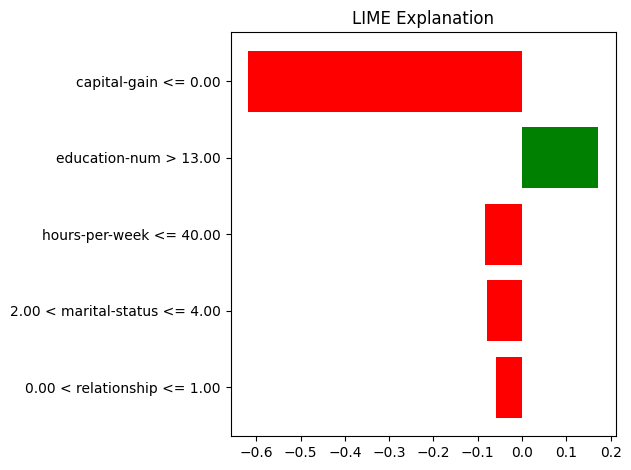

In [10]:
explainer = LimeTabularExplainer(
    X_train.values,
    feature_names=X_train.columns,
    class_names=['<=50K', '>50K'],
    mode='classification'
)

lime_exp = explainer.explain_instance(X_test.iloc[18].values, model.predict_proba, num_features=5)

lime_fig = lime_exp.as_pyplot_figure()
plt.title("LIME Explanation")
plt.tight_layout()

# SHAP

In [ ]:
shap_explainer = shap.TreeExplainer(model)
shap_values = shap_explainer.shap_values(X_test)

plt.figure()
shap.summary_plot(shap_values[1], X_test, show=True)
plt.title("SHAP")
plt.tight_layout()

# Partial Dependence Plot (PDP)

shows how **age**, **hours-per-week**, and **capital-gain** affect the chance of earning >50K using a Random Forest model. **Age** has the highest income chance around 30–50 years. **Hours-per-week** shows income chances rising up to 40 hours. **Capital-gain** shows a increase once it’s above 0.

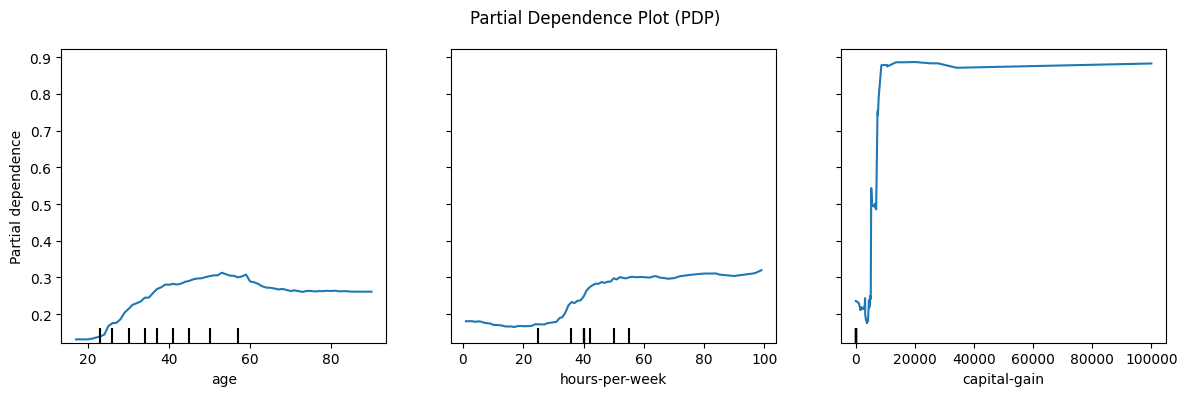

In [12]:
features = ['age', 'hours-per-week', 'capital-gain']
fig, ax = plt.subplots(figsize=(12, 4))
PartialDependenceDisplay.from_estimator(
    model, X_test, features, ax=ax
)
plt.suptitle("Partial Dependence Plot (PDP)")
plt.tight_layout()